# **Variables Analysis of Vertebral Column Dataset**

## Reading dataset and getting global information

In [42]:
# Import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# Use pandas to read csv file and show top 5 rows
dir = 'data/Dataset_spine.csv'
my_data = pd.read_csv(dir)
my_data.head()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,grade of spondylolisthesis,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [44]:
# get descriptive statistics summary
my_data.describe()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,grade of spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


## Plotting numerical variables

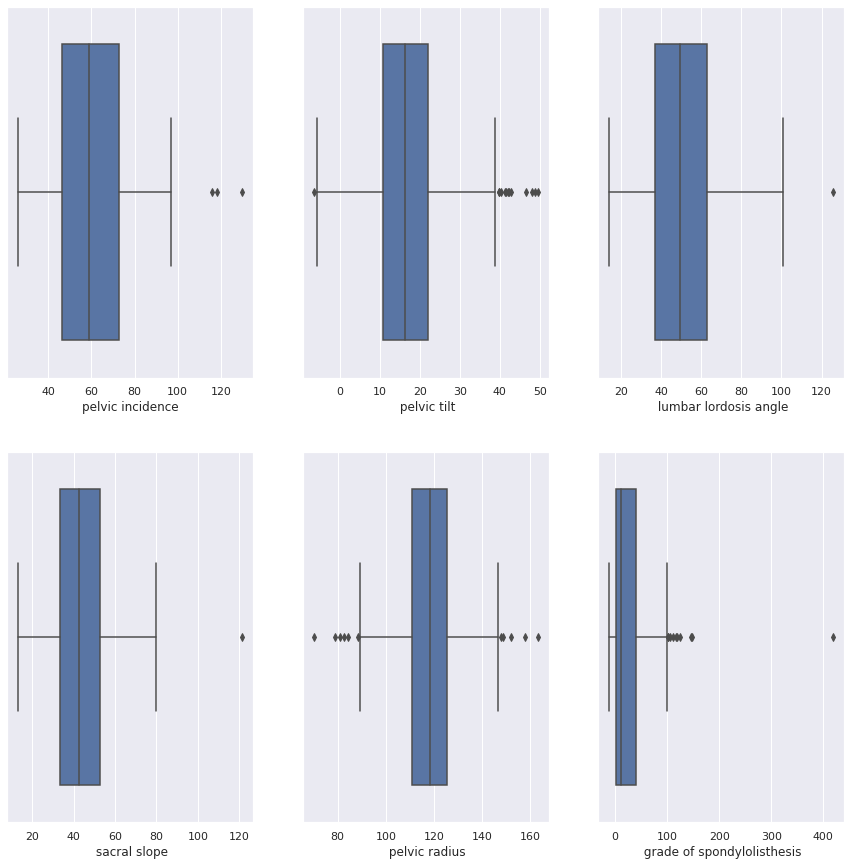

In [45]:
# Define a function to plot each variable (only valid for n_rows > 1)
def boxplot(my_data, n_rows, n_cols):
    # my_data: dataset to plot
    # n_row: number of rows of the graph
    # n_cols: number of columns of the graph
    sns.set()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

    col = 0
    row = 0
    # col and row defines the position of the subplot in the graph
    for column in my_data.columns[:-1]:
        sns.boxplot(data=my_data, x=column, hue='Class_att', ax=axes[col, row])
        if (row<n_rows):
            row=row+1
        elif (row==n_rows):
            row=0
            col=col+1
        else: print('Invalid arguments!')

boxplot(my_data, 2, 3)

The last subplot makes me think that there is at least one outlier. Let's verify it!

## Finding outliers and NaN

The next code shows a first function, that detect and replace outliers or NaN values by the column mean, because all variables are continuous. For this purpose, we are calculating lower (Q1) and upper (Q3) quartiles, so outliers are out of the range $[Q1-1.5·IQR, Q3*1.5·IQR]$, where $IQR = Q3-Q1$.

The second function apply the first one iteratively, because, after a replacement, statistics can change and new outliers appear.

In [46]:
# Define a function to find outliers and NaN values in a dataset, and replace it by the column mean.
def find_outliers(my_data):
    # definition of numeric types
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    # Take numeric columns
    data = my_data.select_dtypes(include=numerics)

    # Take column names
    columns = data.columns
    
    # Set the new dataframe
    out = pd.DataFrame()

    # Number of outliers
    n_outliers = 0

    for column in columns:
        """
        For each column, calculate the lower and the upper fences.
        Iterate each value in the column:
            if the value is between the fences: add to the new column
            it not: dropt it, replace with the column mean and add to the new column
        After iteration, add column to the new dataframe. After  iterate all columns,
        add excluded columns to the dataframe and return it and the number of outliers.
        """
        Q1 = data[column].describe().describe()['25%']
        Q3 = data[column].describe().describe()['75%']
        IQR = Q3-Q1

        lower_fence = Q1 - 1.5*IQR
        upper_fence = Q3 + 1.5*IQR
        
        new_column = pd.Series(dtype='float64')
        for idx, value in enumerate(data[column]):
            """ This conditional statement allows us to replace either outliers or NaN values.
            """
            if ((value >= lower_fence) & (value <= upper_fence)):
                new_value = pd.Series(data=value, index=[idx])
                new_column = pd.concat([new_column, new_value])
            else:
                col_mean  = np.mean(data[column].drop(idx))
                new_value = pd.Series(data=col_mean, index=[idx])
                new_column = pd.concat([new_column, new_value])
                n_outliers = n_outliers + 1
        new_column.name = column
        new_column = pd.DataFrame(new_column)
        out = pd.concat([out, new_column], axis=1)

    excluded_columns = my_data.select_dtypes(exclude=numerics)
    out = pd.concat([out, excluded_columns], axis=1)

    return (out, n_outliers)

In [47]:
# Define a function to apply find_outliers() iteratively
def replace_outliers(my_data):
    """
    While the number of outliers is not equal to 0, the loop will apply the
    function find_outliers(). 
    """
    data = my_data
    n_outliers = -1
    n_loops = 0
    total_outliers = 0

    while(n_outliers != 0):
        data, n_outliers = find_outliers(data)
        n_loops = n_loops+1
        total_outliers = total_outliers + n_outliers
        
    print('***Found a total of '+str(total_outliers)+' outliers over '+str(n_loops)+' iterations.***\n')
    
    return data

Finnaly, save the new dataset into a new variable and show its summary:

In [48]:
new_data = replace_outliers(my_data)
new_data.describe()

***Found a total of 1 outliers over 2 iterations.***



,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,grade of spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,25.027289
std,17.236520,10.008330,18.554064,13.423102,13.317377,30.185249
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,40.788437
max,129.834041,49.431864,125.742385,121.429566,163.071041,148.753711


## Plotting new data

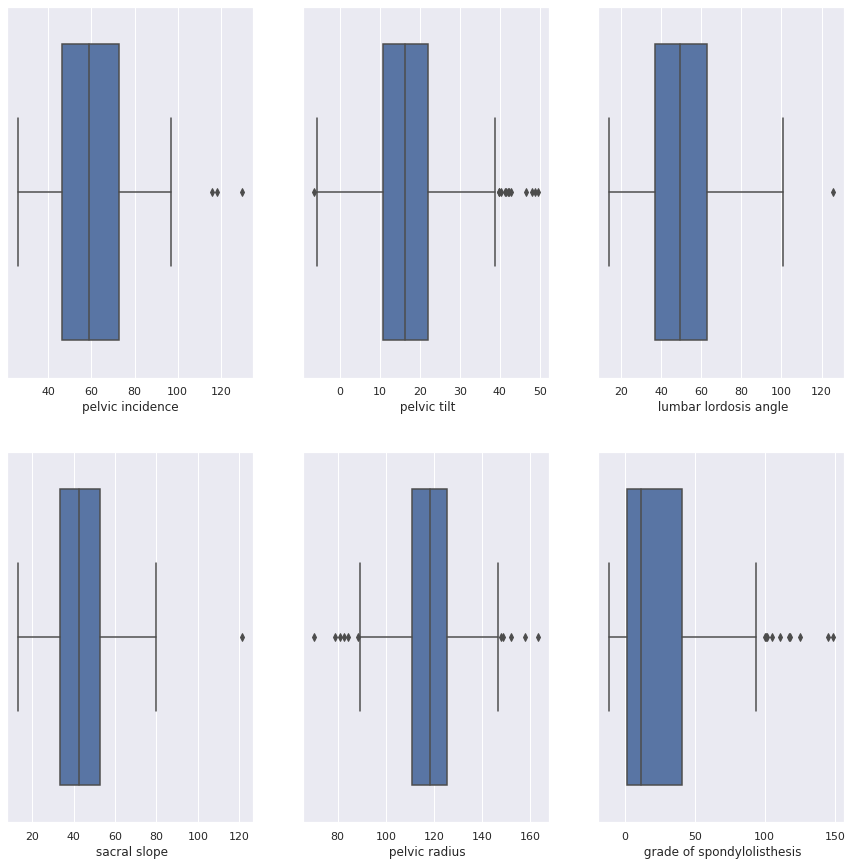

In [49]:
boxplot(new_data, 2, 3)

The last subplot has changed and doesn't show the outlier. Now, we have a new dataset ready to use.

## Store data

In [50]:
from pathlib import Path  
filepath = Path('data/data.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
new_data.to_csv(filepath, index=False)